In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [3]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

In [4]:
df_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')

In [5]:
df_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')

In [6]:
train = pd.merge(df_transaction, df_identity, on='TransactionID', how='left')


# DATA SPLIT

In [7]:
from sklearn.model_selection import train_test_split

unique_cards = train['card1'].unique()


card_train, card_val_test = train_test_split(unique_cards, test_size=0.4, random_state=42)
card_val, card_test = train_test_split(card_val_test, test_size=0.5, random_state=42)


val = train[train['card1'].isin(card_val)]
test = train[train['card1'].isin(card_test)]
train = train[train['card1'].isin(card_train)]

In [8]:
print(train['isFraud'].mean(), val['isFraud'].mean(), test['isFraud'].mean())

print(len(set(train['card1']) & set(val['card1'])))  
print(len(set(train['card1']) & set(test['card1']))) 

0.03513108235162511 0.03890206572198909 0.03122020767664969
0
0


In [9]:
train_ids = train.pop('TransactionID')
y_train = train.pop('isFraud')
x_train = train

val_ids = val.pop('TransactionID')
y_val = val.pop('isFraud')
x_val = val

test_ids = test.pop('TransactionID')
y_test = test.pop('isFraud')
x_test = test

In [10]:
x_train.shape

(375451, 432)

# DATA CLEANER

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
class SmartMissingHandler(BaseEstimator, TransformerMixin):
    def __init__(self, nan_threshold=0.8, fraud_ratio_threshold=2.5, verbose=True):
        self.nan_threshold = nan_threshold
        self.fraud_ratio_threshold = fraud_ratio_threshold
        self.verbose = verbose
        self.high_risk_cols_ = None
        self.cols_to_drop_ = None
        self.mean_fraud_rate_ = None
        
    def _print(self, message):
        if self.verbose:
            print(message)
            
    def fit(self, X, y=None):
        """Identify high-risk columns and columns to drop"""
        X = X.copy()
        self._print("\n=== Starting Fit ===")
        
        nan_rates = X.isnull().mean()
        self.cols_to_drop_ = nan_rates[nan_rates >= self.nan_threshold].index.tolist()
        X = X.drop(columns=self.cols_to_drop_)
        
        if y is not None:
            self.mean_fraud_rate_ = y.mean()
            missing_analysis = []
            
            for col in X.columns:
                if X[col].isnull().sum() > 0:
                    fraud_missing = y[X[col].isnull()].mean()
                    fraud_not_missing = y[~X[col].isnull()].mean()
                    ratio = fraud_missing / max(fraud_not_missing, 1e-6)
                    
                    if ratio >= self.fraud_ratio_threshold:
                        missing_analysis.append({
                            'column': col,
                            'fraud_ratio': ratio,
                            'missing_rate': X[col].isnull().mean()
                        })
            
            self.high_risk_cols_ = [x['column'] for x in 
                                  sorted(missing_analysis, 
                                  key=lambda x: -x['fraud_ratio'])]
        
        return self
    
    def transform(self, X):
        """Apply transformations without DataFrame fragmentation"""
        X = X.copy()
        
        X = X.drop(columns=self.cols_to_drop_, errors='ignore')
        
        flag_data = {}
        impute_data = {}
        
        for col in (self.high_risk_cols_ or []):
            if col in X.columns:
                flag_data[f'{col}_MISSING'] = X[col].isnull().astype(int)
                if pd.api.types.is_numeric_dtype(X[col]):
                    impute_data[col] = X[col].fillna(-999)
                else:
                    impute_data[col] = X[col].fillna('MISSING_CAT')
        
        other_cols = [c for c in X.columns 
                     if c not in (self.high_risk_cols_ or []) 
                     and X[c].isnull().any()]
        
        for col in other_cols:
            mode_val = X[col].mode()[0] if not X[col].mode().empty else (0 if pd.api.types.is_numeric_dtype(X[col]) else 'MISSING')
            impute_data[col] = X[col].fillna(mode_val)
        
        X = X.assign(**impute_data)
        if flag_data:
            X = pd.concat([X, pd.DataFrame(flag_data, index=X.index)], axis=1)
        
        return X

# FEATURE SELECTION

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class CorrelationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9, method='pearson', verbose=True):
        self.threshold = threshold
        self.method = method
        self.verbose = verbose
        self.cols_to_drop_ = []
        
    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        num_cols = X.select_dtypes(include=np.number).columns
        X_num = X[num_cols].replace([np.inf, -np.inf], np.nan)
        
        if X_num.isna().any().any():
            raise ValueError("Found NA values in supposedly clean numeric data")
            
        try:
            corr_matrix = X_num.corr(method=self.method).abs()
        except Exception as e:
            print(f"Correlation failed. Checking problematic columns...")
            problematic = []
            for col in num_cols:
                try:
                    X_num[col].astype(float)
                except:
                    problematic.append(col)
            raise ValueError(f"Non-numeric values found in columns: {problematic}")
        
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.cols_to_drop_ = [col for col in upper.columns 
                            if any(upper[col] >= self.threshold)]
        
        if self.verbose:
            print(f"Removing {len(self.cols_to_drop_)} features with {self.method} corr ‚â• {self.threshold}")
        return self
    
    def transform(self, X):
        return pd.DataFrame(X).drop(columns=self.cols_to_drop_, errors='ignore')

In [11]:
!pip install -U scikit-learn==1.3.2 imbalanced-learn==0.11.0

# TRAINING

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    random_state=42
)

full_pipeline = Pipeline([
    ('nan_handling', SmartMissingHandler(
        nan_threshold=0.80,
        fraud_ratio_threshold=2.5
    )),
    ('ordinal_encoder', OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1
    )),
    ('selector', VarianceThreshold(threshold=0.01)),
    ('correlation_remover', CorrelationRemover(threshold=0.95)),
    ('ada', ada_model)
])

In [26]:
full_pipeline.fit(x_train, y_train)
y_train_pred = full_pipeline.predict_proba(x_train)[:, 1]
y_test_pred = full_pipeline.predict_proba(x_test)[:, 1]

from sklearn.metrics import roc_auc_score
# Calculate ROC-AUC
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print(f"Train ROC-AUC: {train_auc:.4f}")
print(f"Test ROC-AUC: {test_auc:.4f}")


=== Starting Fit ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


Removing 97 features with pearson corr ‚â• 0.95
Train ROC-AUC: 0.8587
Test ROC-AUC: 0.8219


#  MLFLOW LOGGING

In [31]:
!pip install mlflow dagshub

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 260.1/260.1 kB 9.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 203.2/203.2 kB 10.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 74.3/74.3 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: graphql-core
    Found existing installation: graphql-core 3.2.6
    Uninstalling graphql-core-3.2.6:
      Successfully uninstalled graphql-core-3.2.6
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
      Successfully uninstalled dacite-1.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.

In [32]:
import dagshub
dagshub.init(repo_owner='abarb22', repo_name='IEEE-fraud-detection', mlflow=True)

‚ùó‚ùó‚ùó AUTHORIZATION REQUIRED ‚ùó‚ùó‚ùó



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=91f0181b-0ec6-4d0d-bdb7-1be66e2c3c11&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=cd9d95fb0430ea4fe1794d04d158cf2f930783a886987859a346cf2dbcfd8b35




Output()

Accessing as abarb22

Initialized MLflow to track repo "abarb22/IEEE-fraud-detection"

Repository abarb22/IEEE-fraud-detection initialized!

üèÉ View run Preprocessing at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/4/runs/88ae3656c9b34f32b6c82f425a2363fd
üß™ View experiment at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/4
üèÉ View run AdaBoost_FeatureSelection at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/4/runs/d7d10db51cc54d8f8fe13cb06ec5810f
üß™ View experiment at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/4
üèÉ View run AdaBoost_CV_Training at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/4/runs/a4c84712ba514d0bbe7120ee0db7f807
üß™ View experiment at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/4


2025/04/27 16:28:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run AdaBoost_FinalModel at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/4/runs/61646c99a0074983bad8d739f214df66
üß™ View experiment at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/4
üèÉ View run AdaBoost_Trial_1 at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/4/runs/eac37bb7adf64af3a947d2637bbdead5
üß™ View experiment at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/4


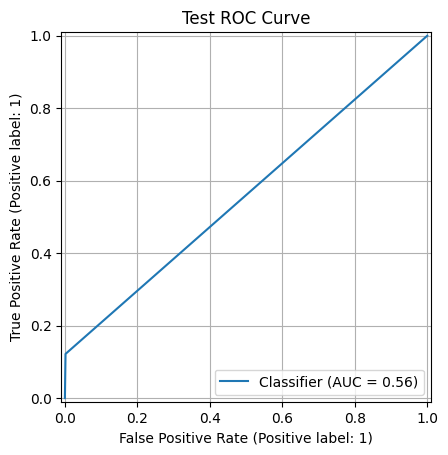

In [34]:
import mlflow
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay, precision_score, recall_score, f1_score
import mlflow.sklearn
import os
import matplotlib.pyplot as plt



mlflow.set_experiment("AdaBoost")

with mlflow.start_run(run_name="AdaBoost_Trial_1") as parent_run:
    with mlflow.start_run(run_name="Preprocessing", nested=True):
        mlflow.log_param("preprocessing", "OrdinalEncoding")
        mlflow.log_param("nan_handler_threshold", 0.8)
        

    with mlflow.start_run(run_name="AdaBoost_FeatureSelection", nested=True):
        mlflow.log_param("variance_threshold", 0.01)
        mlflow.log_param("correlation_threshold", 0.95)
        mlflow.log_param("fraud_ratio_threshold", 2.5)

    with mlflow.start_run(run_name="AdaBoost_CV_Training",  nested=True):
        # Log search space and best hyperparameters
        mlflow.log_param("model", "AdaBoost")
        mlflow.log_param("ada_n_estimators", full_pipeline.named_steps['ada'].n_estimators)
        mlflow.log_param("ada_learning_rate", full_pipeline.named_steps['ada'].learning_rate)

 

    with mlflow.start_run(run_name="AdaBoost_FinalModel", nested=True):
        # Log final metrics
        mlflow.log_metric("train_roc_auc", train_auc)
        mlflow.log_metric("test_roc_auc", test_auc)

        y_test_pred = (y_test_pred > 0.5).astype(int)

        # Log precision, recall, F1 scores
        mlflow.log_metric("test_precision", precision_score(y_test, y_test_pred))
        mlflow.log_metric("test_recall", recall_score(y_test, y_test_pred))
        mlflow.log_metric("test_f1", f1_score(y_test, y_test_pred))

        # Log classification report as text
        report = classification_report(y_test, y_test_pred)
        mlflow.log_text(report, "classification_report.txt")

        # Log model
        mlflow.sklearn.log_model(full_pipeline, "final_model")  # Log the entire pipeline

        # Log ROC curve plot
        RocCurveDisplay.from_predictions(y_test, y_test_pred)
        plt.title("Test ROC Curve")
        plt.grid(True)
        plt.savefig("roc_curve.png")
        mlflow.log_artifact("roc_curve.png")
        

